## Imports

In [3]:
import numpy as np
import netsquid as ns

from netsquid.qubits.ketstates import s0
from netsquid.qubits.state_sampler import StateSampler
from netsquid.qubits.qformalism import QFormalism
from netsquid.nodes.connections import DirectConnection
from netsquid.components.qprocessor import QuantumProcessor
from netsquid.components.qsource import QSource, SourceStatus
from netsquid.components.qchannel import QuantumChannel
from netsquid.nodes.node import Node
from netsquid.components.instructions import IGate
from netsquid.components import T1T2NoiseModel, FibreDelayModel

from n_node_RB import MultiNodeRB
from teleportationnoisemodel import TeleportationNoiseModel

import pickle as pk
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t

## Multi node simulation

In [4]:
t1_time     = 1e9       
t2_time     = 12e6      
gate_time   = 39e3      
alpha       = 0.95
min_bounces = 1
max_bounces = 10
n_samples   = 40
node_counts = [2, 3, 4, 5, 6]
ns.set_qstate_formalism(QFormalism.DM)
for n_nodes in node_counts:
    ns.sim_reset()
    nodes = [Node(f"Node{i}") for i in range(n_nodes)]
    proc0 = QuantumProcessor("QPD0", num_positions=2, mem_noise_models=[T1T2NoiseModel(T1=t1_time, T2=t2_time)] * 2)
    nodes[0].qmemory = proc0
    for i in range(1, n_nodes):
        proc = QuantumProcessor(f"QPD{i}", num_positions=1, mem_noise_models=[T1T2NoiseModel(T1=t1_time, T2=t2_time)])
        nodes[i].qmemory = proc
    sampler = StateSampler([s0], probabilities=[1.0])
    source  = QSource("QSource", state_sampler=sampler, status=SourceStatus.EXTERNAL)
    nodes[0].add_subcomponent(source)
    for i in range(n_nodes - 1):
        ch_up = QuantumChannel(f"TelChannel{i}{i+1}", length=40, models={"delay_model":    FibreDelayModel(), "quantum_noise_model": TeleportationNoiseModel(alpha=alpha)})
        ch_dn = QuantumChannel(f"TelChannel{i+1}{i}", length=40, models={"delay_model":    FibreDelayModel(), "quantum_noise_model": TeleportationNoiseModel(alpha=alpha)})
        conn = DirectConnection(f"Conn{i}{i+1}", ch_up, ch_dn)
        nodes[i].connect_to(nodes[i+1], conn, label=f"quantum{i}{i+1}")
    rb = MultiNodeRB(nodes=nodes, min_bounces=min_bounces, max_bounces=max_bounces, n_samples=n_samples)
    for instr in rb.cliffords:
        for node in nodes:
            node.qmemory.add_instruction(instr, duration=gate_time, topology=[0], q_noise_model=T1T2NoiseModel(T1=t1_time, T2=t2_time))
    rb.start()
    ns.sim_run()
    mean_fids, all_seq_fids = rb.get_fidelity()
    data = {"decay_data": (mean_fids, all_seq_fids), "endpoints": [min_bounces, max_bounces]}
    with open(f"{n_nodes}_RB_decay.pickle", "wb") as f:
        pk.dump(data, f)

## Plotting


/tmp/ipykernel_21497/2685661035.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  g.show()


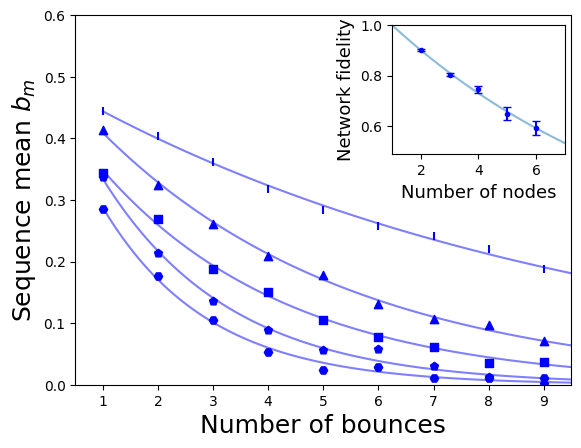

In [5]:
plt.close()
def exp(m,A,f):
	return A* f**m
fid  = {}
popt = {}
pcov = {}
g = plt.figure(1)
ax = plt.subplot()
n_nodes = [2,3,4,5,6]
symbols = {2:"|",3:"^", 4:"s", 5:"p", 6:"H"}
for i in n_nodes:
	with open(f"{i}_RB_decay.pickle", 'rb') as f:
		fid[i] = pk.load(f)
	endp = fid[i]["endpoints"]
	datp= [ fid[i]["decay_data"][0][x] for x in range(*endp)]
	popt[i],pcov[i] = curve_fit(exp,np.array(range(*endp)), datp )
	ax.axis([0.5,endp[1]-0.5, 0,0.6])
	ax.scatter(np.array(range(*endp)), datp, marker = symbols[i], color = "b")
	ax.plot(np.linspace(*endp,100), 
		[exp(m, *popt[i]) for m in np.linspace(*endp,100)],alpha = 0.5,color = "b")
	for k in range(*endp):
		dats =  fid[i]["decay_data"][1][k]
		loc = [k for x in range(len(dats))]
sub = plt.axes([0.62,0.59,0.27,0.27])
sub.axis([1,7,0.49,1])
fidopt,fidcov = curve_fit(exp, n_nodes, [popt[i][1] for  i in n_nodes])
sub.plot(np.linspace(n_nodes[0]-1,n_nodes[-1]+1,100), [exp(m, *fidopt) for m in np.linspace(n_nodes[0]-1,n_nodes[-1]+1,100)],alpha = 0.5)
sub.set_xlabel("Number of nodes",fontsize=13)
sub.set_ylabel("Network fidelity",fontsize=13)
h = t.ppf((1 +0.95) / 2., 18-2)
sub.errorbar(n_nodes, [popt[i][1] for i in n_nodes], yerr=[h* np.sqrt(pcov[i][1,1]) for i in n_nodes], capsize=3,marker="o",ms=3,ls="",color="b")
ax.set_xlabel("Number of bounces",fontsize=18)
ax.set_ylabel("Sequence mean $b_m$",fontsize=18)
g.savefig("n_node_netrb",transparent=True)
g.show()
plt.show()

